In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization

[12/20/2020 02:11:25 INFO] Generating new fontManager, this may take some time...


## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [10]:
dataset = Path('datasets')
images = dataset / 'South-Building/images/'

model_name = 'superpoint'

outputs = Path('outputs/sfm/')
sfm_dir = outputs / f'sfm_superpoint+{model_name}'
sfm_pairs = sfm_dir / 'pairs-exhaustive.txt'  # exhaustive matching

feature_conf = extract_features.confs[f'{model_name}_aachen']
matcher_conf = match_features.confs['superglue']

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data, and refined with SfM.

In [3]:
%%bash -s "$dataset"
wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P $1
unzip datasets/South-Building.zip -d $1

--2020-12-20 02:13:38--  http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip
Resolving cvg.ethz.ch (cvg.ethz.ch)... 129.132.85.27
Connecting to cvg.ethz.ch (cvg.ethz.ch)|129.132.85.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230948942 (220M) [application/zip]
Saving to: 'datasets/sfm_South-Building/South-Building.zip'

     0K .......... .......... .......... .......... ..........  0%  158K 23m45s
    50K .......... .......... .......... .......... ..........  0%  158K 23m45s
   100K .......... .......... .......... .......... ..........  0%  316K 19m48s
   150K .......... .......... .......... .......... ..........  0%  316K 17m49s
   200K .......... .......... .......... .......... ..........  0% 86.3M 14m15s
   250K .......... .......... .......... .......... ..........  0%  317K 13m51s
   300K .......... .......... .......... .......... ..........  0% 83.4M 11m52s
   350K .......... .......... .......... .......... ..........  0% 

CalledProcessError: Command 'b'wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P $1\nunzip datasets/South-Building.zip -d $1\n'' returned non-zero exit status 9.

## Extract local features

In [11]:
feature_path = extract_features.main(feature_conf, images, outputs)

[12/21/2020 08:36:33 INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
Loaded SuperPoint model
[12/21/2020 08:36:33 INFO] Found 128 images in root datasets/South-Building/images.


  0%|          | 0/128 [00:00<?, ?it/s]/app/hloc/extractors/../../third_party/SuperGluePretrainedNetwork/models/superpoint.py:181: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  for s in scores]
100%|██████████| 128/128 [00:39<00:00,  3.24it/s]

[12/21/2020 08:37:12 INFO] Finished exporting features.


## Exhaustive matching
Since the dataset is small, we can match all $\frac{n(n-1)}{2}$ images pairs. To do so, we pass the argument `exhaustive=True` and make sure that the pair file does not exist yet. If your dataset is larger, exhaustive matching might take a long time - consider selecting fewer pairs using image retrieval and `hloc/pairs_from_retrieval.py`.

In [12]:
sfm_pairs.parent.mkdir(parents=True, exist_ok=True)
match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf['output'], outputs, exhaustive=True)

[12/21/2020 08:37:12 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[12/21/2020 08:37:12 INFO] Writing exhaustive match pairs to outputs/sfm/sfm_superpoint+superpoint/pairs-exhaustive.txt.


  0%|          | 0/8128 [00:00<?, ?it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 8128/8128 [45:46<00:00,  2.96it/s]

[12/21/2020 09:22:59 INFO] Finished exporting matches.


## SfM reconstruction
Run COLMAP on the features and matches.

In [13]:
reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[12/21/2020 09:22:59 INFO] Creating an empty database...
[12/21/2020 09:23:00 INFO] Importing images into the database...
[12/21/2020 09:23:08 INFO] Importing features into the database...


100%|██████████| 128/128 [00:00<00:00, 393.79it/s]


[12/21/2020 09:23:08 INFO] Importing matches into the database...


100%|██████████| 8128/8128 [00:05<00:00, 1430.82it/s]


[12/21/2020 09:23:15 INFO] Performing geometric verification of the matches...
[12/21/2020 09:25:53 INFO] Running the 3D reconstruction...
[12/21/2020 09:25:53 INFO] colmap mapper --database_path outputs/sfm/sfm_superpoint+superpoint/database.db --image_path datasets/South-Building/images --output_path outputs/sfm/sfm_superpoint+superpoint/models --Mapper.num_threads 16
[12/21/2020 09:33:15 INFO] Reconstructed 1 models.
[12/21/2020 09:33:15 INFO] Largest model is #0 with {largest_model_num_images} images.
[12/21/2020 09:33:16 INFO] Statistics:
{'mean_reproj_error': 1.390636,
 'mean_track_length': 4.601145,
 'num_input_images': 128,
 'num_observations': 244330,
 'num_observations_per_image': 1908.828125,
 'num_reg_images': 128,
 'num_sparse_points': 53102}


## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

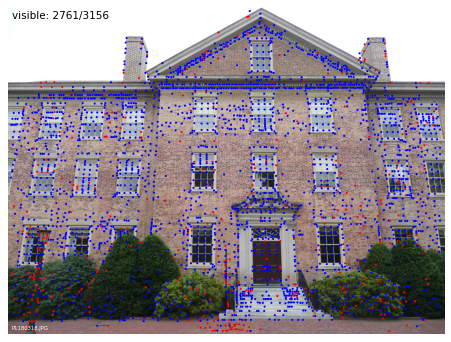

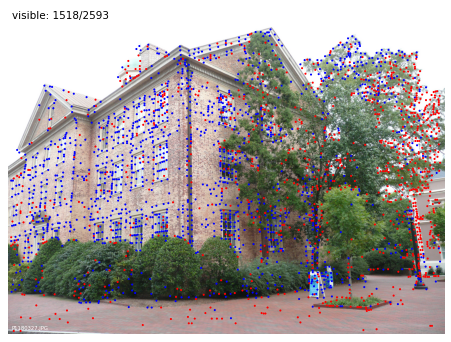

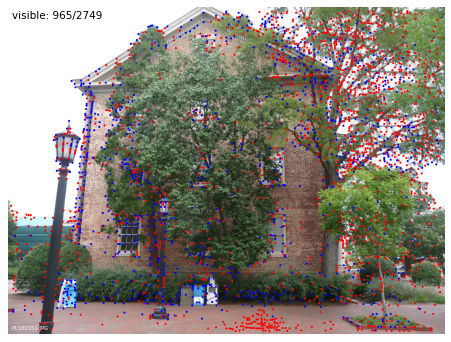

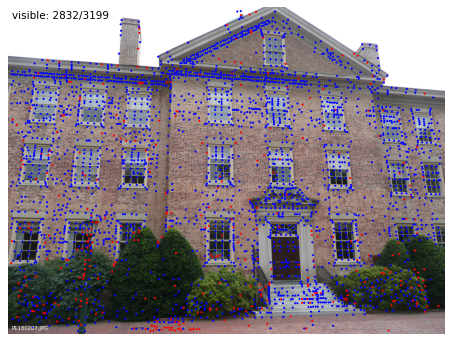

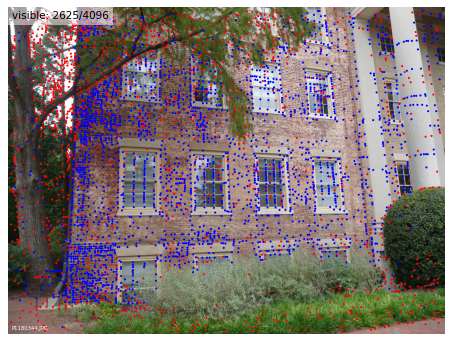

In [14]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='visibility', n=5)

In [ ]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='track_length', n=5)

In [ ]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='depth', n=5)